### Amazon Fine Food Reviews Analysis


    Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

    EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


    The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

    Number of reviews: 568,454
    Number of users: 256,059
    Number of products: 74,258
    Timespan: Oct 1999 - Oct 2012
    Number of Attributes/Columns in data: 10 

    Attribute Information:

    1. Id
    2. ProductId - unique identifier for the product
    3. UserId - unqiue identifier for the user
    4. ProfileName
    5. HelpfulnessNumerator - number of users who found the review helpful
    6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    7. Score - rating between 1 and 5
    8. Time - timestamp for the review
    9. Summary - brief summary of the review
    10. Text - text of the review


    #### Objective:
    Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

    
    [Q] How to determine if a review is positive or negative?
    [Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [29]:
# imports needed

import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re

import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


### Reading Data

In [30]:
# using the SQLite Table to read data.

con = sqlite3.connect('database2.sqlite')
# filtering only positve and negative reviews i.e.
# not taking into consideration those review with score = 3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'",con)
print(tables)
filtered_data = pd.read_sql_query("Select * from Reviews Where Score != 3 LiMIT 50000",con)

# Give reviews with Score > 3 a positive rating and reviews with a score < 3 a negative rating.

def partition(x):
    if x < 3:
        return 0
    return 1

# changing review with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Shape",filtered_data.shape)
print(filtered_data.head(3))

      name
0  Reviews
Shape (50000, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  


In [31]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*) 
FROM Reviews 
GROUP BY UserId 
HAVING COUNT(*) > 1
""",con)

In [32]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [33]:
display[display['UserId'] == "AZY10LLTJ71NX"]

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [34]:
display['COUNT(*)'].sum()

393063

### Exploratory Data Analysis
### [2] Data Cleaning: Deduplication

It is observed(as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbaised results for the analysis of the data. Following is an example:

In [35]:
display = pd.read_sql_query("""
SELECT * from Reviews 
WHERE Score != 3 AND UserId = 'AZY10LLTJ71NX' 
ORDER BY ProductID
""",con)

display.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,333057,B000MYW2ZA,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",0,0,5,1334707200,works for me. lost 10-15 pounds my first month,I was recommended to try green tea extract to ...
1,35174,B001ATMQK2,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,5,1296691200,Have you seen how much Ranch 99 is trying to c...,I bought this 6 pack because for the price tha...
2,332195,B001P7AXXG,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,5,1303776000,BEST MICROWAVE POPCORN EVER!!!!,This popcorn is probably the best microwave po...
3,340773,B0043CVIBG,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",4,4,5,1303776000,girl scout thin mint in disguise,if you love thin mint cookies that the girl sc...
4,404703,B006P7E5ZI,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",0,0,5,1334707200,works for me. lost 10-15 pounds my first month,I was recommended to try green tea extract to ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 


ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)


ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on


It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.
The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [36]:
# Sorting data according to productId in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis = 0, ascending = True, inplace = False, kind = 'quicksort',na_position='last')

In [37]:
# Deduplication Of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [38]:
#Checking to see how much % of data still remains
(final['Id'].size * 1.0)/(filtered_data['Id'].size * 1.0) * 100

92.144

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [39]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [40]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [41]:
# Before starting the next phase of preprocessing lets see the number of emtries left
print(final.shape)

# How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [42]:
# printing some random reviews
sent_0 = final['Text'][0]
print(sent_0)
print("=" * 50)

sent_1000 = final['Text'][1000]
print(sent_1000)
print("=" * 100)

sent_1500 = final['Text'][1500]
print(sent_1500)
print("=" * 100)

sent_4900 = final['Text'][4900]
print(sent_4900)
print("=" * 100)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Gatorade G2 is the way to go when you want the benefits of Gatorade without quite so much sugar. As I am in a "pre-diabetes" state these days, I am drinking this type of Gatorade instead of the regular Gatorade which has noticeably more sugar in it. The really good thing is that this still replenishes carbs and electrolytes after I exercise without putting unnecessary extra sugar into my system.<br /><br />G2 comes in flavors including fruit punch and grape.<br /><br />If you're on the go, the advantage of these bottles of Gatorade is this: because the bottles are smaller you can carry them with you much easier than if you took the regular, larger size bottles of Gatorade G2.<br /><br />I highly recommend this drink if you nee

In [43]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+","",sent_0)
print(sent_0)
print("=" * 100)

sent_1000 = re.sub(r"http\S+", "", sent_1000)
print(sent_1000)
print("=" * 100)

sent_1500 = re.sub(r"http\S+", "", sent_1500)
print(sent_1500)
print("=" * 100)

sent_4900 = re.sub(r"http\S+", "", sent_4900)
print(sent_4900)
print("=" * 100)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Gatorade G2 is the way to go when you want the benefits of Gatorade without quite so much sugar. As I am in a "pre-diabetes" state these days, I am drinking this type of Gatorade instead of the regular Gatorade which has noticeably more sugar in it. The really good thing is that this still replenishes carbs and electrolytes after I exercise without putting unnecessary extra sugar into my system.<br /><br />G2 comes in flavors including fruit punch and grape.<br /><br />If you're on the go, the advantage of these bottles of Gatorade is this: because the bottles are smaller you can carry them with you much easier than if you took the regular, larger size bottles of Gatorade G2.<br /><br />I highly recommend this drink if you nee

In [44]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0,'lxml')
text = soup.get_text()
print(text)
print("=" * 100)

soup = BeautifulSoup(sent_1000,'lxml')
text = soup.get_text()
print(text)
print("=" * 100)

soup = BeautifulSoup(sent_1500,'lxml')
text = soup.get_text()
print(text)
print("=" * 100)

soup = BeautifulSoup(sent_4900,'lxml')
text = soup.get_text()
print(text)
print("=" * 100)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Gatorade G2 is the way to go when you want the benefits of Gatorade without quite so much sugar. As I am in a "pre-diabetes" state these days, I am drinking this type of Gatorade instead of the regular Gatorade which has noticeably more sugar in it. The really good thing is that this still replenishes carbs and electrolytes after I exercise without putting unnecessary extra sugar into my system.G2 comes in flavors including fruit punch and grape.If you're on the go, the advantage of these bottles of Gatorade is this: because the bottles are smaller you can carry them with you much easier than if you took the regular, larger size bottles of Gatorade G2.I highly recommend this drink if you need extra carbs or electrolytes after 

In [45]:
# https://stackoverflow.com/a/47091490/4084039

import re

def decontracted(phrase):
#     specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
#     general n't, 're, 's, 'd, 'll, 't, 've, 'm
# correspinding words not, are, is, would, will, not, have, am
    phrase = re.sub(r"n\'t", "not", phrase)
    phrase = re.sub(r"\'re", "are", phrase)
    phrase = re.sub(r"\'s", "is", phrase)
    phrase = re.sub(r"\'d", "would", phrase)
    phrase = re.sub(r"\'ll", "will", phrase)
    phrase = re.sub(r"\'t", "not", phrase)
    phrase = re.sub(r"\'ve", "have", phrase)
    phrase = re.sub(r"\'m", "am", phrase)
    
    return phrase
    

In [46]:
sent_4900 = decontracted(sent_4900)
print(sent_4900)
print("*" * 100)

I like my chocolate tempered to some level of crispness. These nuts were chewy, not crunchy, and the chocolate coating was a bit mealy.<br />If you know anything about dark chocolate, and like yours with some snap, donot order these.<br /><br />Actually, the best dark chocolate covered walnuts are called Perigord and are available through a Canadian company called Kis Global.<br />They are sun dried, super crispy, covered in a fairly thin shell of 70% dark chocolate, and dusted with unsweetened cocoa.<br />Very adult and superb.
****************************************************************************************************


In [47]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*d\S*","",sent_0).strip()
print(sent_0)

I have bought several of the Vitality      have  them all to be of  quality. The  looks more like a stew than a  meat  it smells better. My  is finicky  she appreciates this  better than  most.


In [48]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9 ]+', ' ', sent_1500)
print(sent_1500)

These chips are very tasty   Its a nice size serving and only 100 calories   Good grab and go snack for busy Moms


In [49]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [50]:
# Combining all the above students

from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:12<00:00, 3835.06it/s]


In [51]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

In [52]:
len(preprocessed_reviews)

46071

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [53]:
# Similarly you can also do preprocessing for reviews also

In [54]:
# Printing some random summary
countVal = final['Summary'].count()
random = np.random.randint(4,countVal,4)
for i in random:
    sort_0 = final['Summary'][i]
    print(sort_0)
    print("*" * 100)

Compares Favorably to Starbucks Dark Roast
****************************************************************************************************
Excellent for administering regular medications
****************************************************************************************************
Great tasting chips alternative
****************************************************************************************************
Great candy
****************************************************************************************************


In [55]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
for i in random:
    sent_0 = final['Summary'][i]
    sent_0 = re.sub(r"http\S+","",sent_0)
    print(sent_0)
    print("*" * 100)

Compares Favorably to Starbucks Dark Roast
****************************************************************************************************
Excellent for administering regular medications
****************************************************************************************************
Great tasting chips alternative
****************************************************************************************************
Great candy
****************************************************************************************************


In [56]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

from bs4 import BeautifulSoup

for i in random:
    sent_0 = final['Summary'][i]
    sent_0 = BeautifulSoup(sent_0,'lxml')
    print(sent_0.get_text())
    print("*" * 100)
    

Compares Favorably to Starbucks Dark Roast
****************************************************************************************************
Excellent for administering regular medications
****************************************************************************************************
Great tasting chips alternative
****************************************************************************************************
Great candy
****************************************************************************************************


In [57]:
# https://stackoverflow.com/a/47091490/4084039

# Changing the wordds like 're to are, 's to is etc.

def deContracted(phrase):
#     sepcific
    phrase = re.sub(r"won\'t","will not",phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
#     general
    phrase = re.sub(r"n\'t", " not" ,phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [58]:
for i in random:
    sent_0 = final['Summary'][i]
    sent_0 = deContracted(sent_0)
    print(sent_0)
    print("*" * 50)

Compares Favorably to Starbucks Dark Roast
**************************************************
Excellent for administering regular medications
**************************************************
Great tasting chips alternative
**************************************************
Great candy
**************************************************


In [59]:
# remove words with numbers:
for i in random:
    sent_0 = final['Summary'][i]
    sent_0 = re.sub(r"\S*\d\S*", "", sent_0)
    print(sent_0)
    print("*" * 100)

Compares Favorably to Starbucks Dark Roast
****************************************************************************************************
Excellent for administering regular medications
****************************************************************************************************
Great tasting chips alternative
****************************************************************************************************
Great candy
****************************************************************************************************


In [60]:
# remove special characters
for i in random:
    sent_0 = final['Summary'][i]
    sent_0 = re.sub('[^A-Za-z0-9]+', "", sent_0)
    print(sent_0)
    print("*" * 100)

ComparesFavorablytoStarbucksDarkRoast
****************************************************************************************************
Excellentforadministeringregularmedications
****************************************************************************************************
Greattastingchipsalternative
****************************************************************************************************
Greatcandy
****************************************************************************************************


In [61]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [62]:
# Combining all the above steps
from tqdm import tqdm
preprocessed_summary = []

# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
#     1) remove urls
    sentence = re.sub(r"http\S+", "", sentence)
#     2) remove html or xml tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
#     3) remove "'" like 's with is, 're with are
    sentence = deContracted(sentence)
#     4) remove numbers
    sentence = re.sub(r"\S*\d\S*", "", sentence)
#     5) remove special characters
    sentence = re.sub('[^A-Za-z]+',' ', sentence)
#     6) remove stop words
    sentence = " ".join(e.lower() for e in sentence.split() if e not in stopwords)
    
    preprocessed_summary.append(sentence.strip())
    


100%|██████████| 46071/46071 [00:08<00:00, 5674.25it/s]


In [63]:
for i in random:
    print(preprocessed_summary[i])

mcvitie best
gluten free the way
excellent chocolate
walnuts


# [4] Featurization

## [4.1] BAG OF WORDS

In [64]:
# BOW
count_vect = CountVectorizer() # in scikit-learn
count_vect.fit(preprocessed_reviews)
print("Some feature names")
print(count_vect.get_feature_names()[:30])
print("*" * 100)

final_counts = count_vect.transform(preprocessed_reviews)
print("Type of final_counts")
print(type(final_counts))
print("*" * 100)
print("Shape of BOW final_counts")
print(final_counts.shape)
print("*" * 100)
print("Number of unique words")
print(final_counts.get_shape()[1])

Some feature names
['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand', 'aaah', 'aachen', 'aadp', 'aaf', 'aafco', 'aah', 'aahhhs', 'aahing', 'aahs', 'aarthur', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abates', 'abb', 'abberline', 'abbey', 'abbott']
****************************************************************************************************
Type of final_counts
<class 'scipy.sparse.csr.csr_matrix'>
****************************************************************************************************
Shape of BOW final_counts
(46071, 40750)
****************************************************************************************************
Number of unique words
40750


## Bi-Grams and n-Grams

In [65]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice

count_vect_bi_gram = CountVectorizer(ngram_range=(1,2), min_df=10, max_df=5000)
final_bi_gram = count_vect_bi_gram.fit_transform(preprocessed_reviews)
print("type of final_bi_gram")
print(type(final_bi_gram))
print("*" * 100)

print("shape")
print(final_bi_gram.get_shape())
print("*" * 100)

print("unique words")
print(final_bi_gram.get_shape()[1])

type of final_bi_gram
<class 'scipy.sparse.csr.csr_matrix'>
****************************************************************************************************
shape
(46071, 27877)
****************************************************************************************************
unique words
27877


### TF-IDF

In [66]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("Some sample words in the corpus")
print(tf_idf_vect.get_feature_names()[:10])
print("*" * 100)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("Type")
print(type(final_tf_idf))
print("*" * 100)
print("shape")
print(final_tf_idf.shape)
print("*" * 100)
print("Unique words count")
print(final_tf_idf.get_shape()[1])

Some sample words in the corpus
['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
****************************************************************************************************
Type
<class 'scipy.sparse.csr.csr_matrix'>
****************************************************************************************************
shape
(46071, 27906)
****************************************************************************************************
Unique words count
27906


### Word2Vect

In [67]:
# Train your own Word2Vec model using your own text corpus
i = 0
list_of_sentence = []
for sentence in preprocessed_reviews:
    list_of_sentence.append(sentence.split())

In [68]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g = True
want_to_use_google_w2v = True
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5, considers only words that occured atleast 5 times
    w2v_model = Word2Vec(list_of_sentence,min_count = 5, size = 50, workers = 4)
    print(w2v_model.wv.most_similar('great'))
    print("*" * 100)
    print(w2v_model.wv.most_similar('worst'))
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8418029546737671), ('fantastic', 0.808163046836853), ('terrific', 0.8061028718948364), ('good', 0.8040550947189331), ('amazing', 0.7850069999694824), ('excellent', 0.7812004089355469), ('wonderful', 0.774754524230957), ('perfect', 0.7623196244239807), ('decent', 0.7286362051963806), ('fabulous', 0.7093615531921387)]
****************************************************************************************************
[('nastiest', 0.7283749580383301), ('best', 0.7269394993782043), ('greatest', 0.6859476566314697), ('experienced', 0.6617382764816284), ('ive', 0.652580201625824), ('tastiest', 0.6440903544425964), ('youhave', 0.6378548741340637), ('ihave', 0.6240767240524292), ('awful', 0.6213126182556152), ('eaten', 0.6054084300994873)]


In [69]:
w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occured minimum 5 times")
print(len(w2v_words))

print("*" * 100)
print("Sample words")
print(w2v_words[0:50])

Number of words that occured minimum 5 times
13011
****************************************************************************************************
Sample words
['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'canot', 'beat', 'great', 'received']


### Coverting text into vectors using wAvg W2V,  TFIDF-W2V

#### Avg W2v

In [70]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 
#     if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
#             print(word)
            vec = w2v_model.wv[word]
#             print(vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(type(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46071/46071 [01:01<00:00, 751.39it/s] 


46071
<class 'list'>
50


#### [4.4.1.2] TFIDF weighted W2v

In [71]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)

# we are converting a dictionary with words as a key, and the idf as values
dictionary = dict(zip(model.get_feature_names(),list(model.idf_)))

In [72]:
# TF-IDF weighted word2vec

tfid_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is sparse matrix with row = sentence, col = word and cell_val = tfidf
tfidf_sent_vectors = [];
row = 0;
for sent in tqdm(list_of_sentence):# for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0 # num of words with a valid vector in the sentence/review
    for word in sent:
        if word in w2v_words and word in tfid_feat:
            vec = w2v_model.wv[word]
            
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            
            tf_idf = dictionary[word] * (sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


100%|██████████| 46071/46071 [09:35<00:00, 80.07it/s] 


1000
(1000, 40750)


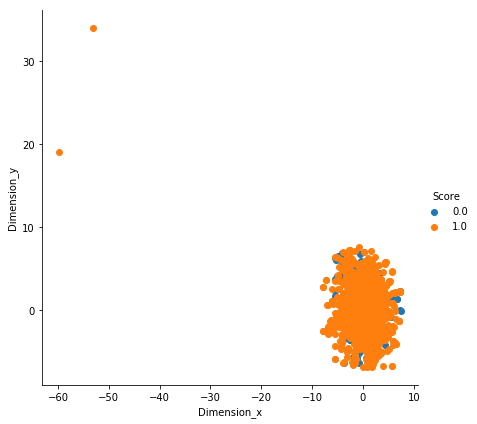

In [73]:
# applying TSNE
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

data = final_counts[:1000]
labels = final['Score']
label_y = labels[:1000]
print(len(label_y))
print(data.shape)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(data.toarray())
for_tsne = np.vstack((X_embedding.T, label_y)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(data=for_tsne_df, hue="Score", height=6)\
    .map(plt.scatter,"Dimension_x","Dimension_y")\
    .add_legend();
plt.show()



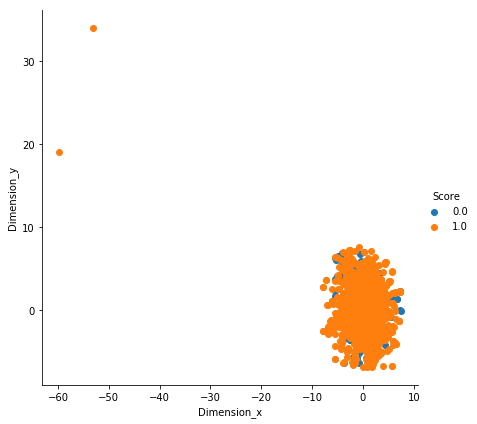

In [74]:
# applying TSNE on bigrams
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

data = final_bi_gram[:1000]
labels = final['Score']
label_y = labels[:1000]

tsne = TSNE(n_components = 2, perplexity = 50, learning_rate = 200)
x_embedding = tsne.fit_transform(data.toarray())
tsne_data = np.vstack((x_embedding.T,label_y)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=["Dimension1","Dimension2","Score"])

sns.FacetGrid(data=for_tsne_df, hue="Score", height=6)\
    .map(plt.scatter,"Dimension_x","Dimension_y")\
    .add_legend();
plt.show()


### [5.1] Applying TNSE on Text TFIDF vectors

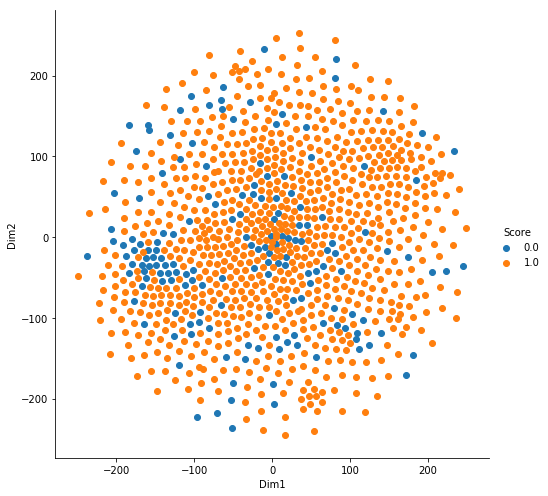

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

data = final_tf_idf[:1000]
labels = final['Score']
label_y = labels[:1000]

tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=200)
x_embedding = tsne.fit_transform(data.toarray())
tsne_data = np.vstack((x_embedding.T,label_y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim1","Dim2","Score"))

sns.FacetGrid(data=tsne_df, hue='Score', height=7)\
    .map(plt.scatter,"Dim1","Dim2")\
    .add_legend()

plt.show()


### [5.3] Applying TNSE on Text Avg W2V vectors

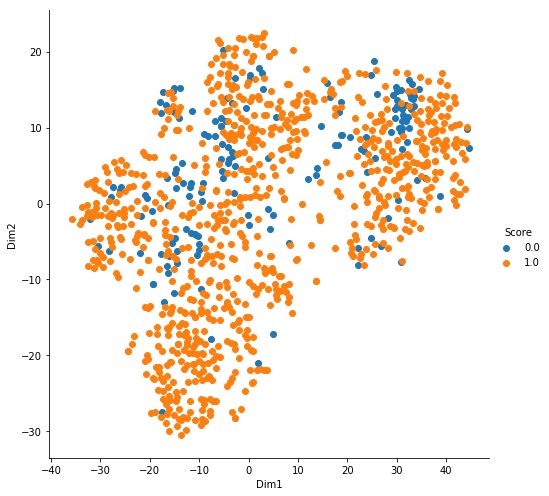

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

data = sent_vectors[:1000]
labels = final['Score']
label_y = labels[:1000]

tsne_model = TSNE(n_components=2, perplexity=30, learning_rate=200)

x_embedding = tsne_model.fit_transform(data)

tsne_data = np.vstack((x_embedding.T,label_y)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=("Dim1","Dim2","Score"))
sns.FacetGrid(data=tsne_df, hue="Score", height = 7)\
    .map(plt.scatter,"Dim1","Dim2")\
    .add_legend()
plt.show()

### [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

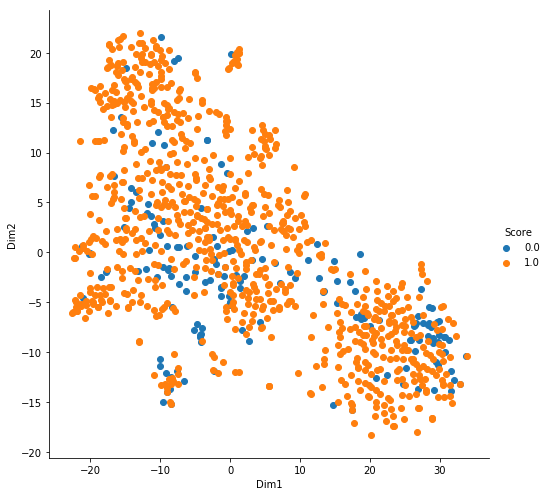

In [77]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data = tfidf_sent_vectors[:1000]
label = final['Score']
label_y = label[:1000]

tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=200)

x_embedding = tsne_model.fit_transform(data)

tsne_data = np.vstack((x_embedding.T, label_y)).T

tsne_df = pd.DataFrame(data=tsne_data,columns=("Dim1","Dim2","Score"))

sns.FacetGrid(data=tsne_df, hue="Score", height=7)\
    .map(plt.scatter,"Dim1","Dim2")\
    .add_legend()
plt.show()
